# Predictive Maintenance 
## Table of contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Data Analysis](#section-5)
* [Fit a Regression model](#section-6)
* [Evaluate the trained model](#section-7)
* [Save the model](#section-8)
* [Running a notebook end-to-end using **Executor**](#section-9)
* [Hosting the model on Vertex AI](#section-10)
   * [Create an Endpoint](#section-11)
   * [Deploy the model to the created Endpoint](#section-12)
   * [Test calling the endpoint](#section-13)
* [Clean up](#section-14)


## Overview
<a name="section-1"></a>
This notebook demonstrates performing predictive maintenance on industrial data using machine learning techniques, deploying the machine learning model on Vertex-AI and automating the workflow using executor feature of Vertex-AI.

<b>Note</b>: This notebook is designed to run on managed notebooks instance of Vertex AI Workbench. Some components of this notebook may not work in other notebook environments.

## Dataset
<a name="section-2"></a>
The dataset used in this notebook is a part of the [NASA Turbofan Engine Degradation Dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) which consists of simulated time-series data for four sets of fleet-engines under different combinations of operational conditions and fault modes. In this notebook, only one of the engine's simulated data(FD001) has been considered to analyze and train a model that can predict the engine's remaining useful life.

## Objective
<a name="section-3"></a>
In this notebook :

- Loading the required dataset from Cloud Storage bucket.
- Analysizing the fields present in the dataset.
- Selecting the required data for the predictive maintenance model.
- Training an XGBoost regression model for predicting the remaining useful life.
- Evaluating the model.
- Running the notebook end-to-end as a training job using Executor.
- Deploying the model on Vertex-AI.
- Clean up.


## Costs
<a name="section-4"></a>
This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Kernel selection
Select <b>XGBoost</b> kernel while running this notebook on Vertex-AIs managed instances or ensure that the following libraries are installed in the environment where this notebook is being run.
- XGBoost
- Pandas
- Seaborn
- Sklearn

Along with the above libraries, the following google-cloud libraries are also used in this notebook.

- google.cloud.aiplatform
- google.cloud.storage

## Set your project ID

In [1]:
PROJECT_ID = "[your-project-id]"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

## Select or Create Cloud Storage Bucket for storing the model

When you create a model resource on Vertex-AI using the Cloud SDK, you need to give a Cloud Storage bucket uri of the model where the model is stored. Using the model saved, you can then create Vertex AI model and endpoint resources in order to serve online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.You may also change the REGION variable, which is used for operations throughout the rest of this notebook. Make sure to choose a region where Vertex AI services are available.

In [49]:
BUCKET_NAME = "[your-bucket-name]"
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "us-central1"

In [47]:
## Set a default bucketname in case bucket name is not given
if BUCKET_NAME == "" or BUCKET_NAME is None :
    from datetime import datetime
    
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    BUCKET_NAME =  PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" +BUCKET_NAME

<b>Only if your bucket doesn't already exist</b>: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Next, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

## Import the required libraries

In [4]:
## load the required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

import os
from google.cloud import storage
from google.cloud import aiplatform

Load the data and check the data shape.

In [6]:
## load the data from the source
INPUT_PATH = 'gs://vertex_ai_managed_services_demo/mfg_predictive_maintenance/train_FD001.txt' # data source
raw_data = pd.read_csv(INPUT_PATH, sep=' ', header = None)
# check the data
print (raw_data.shape)
raw_data.head()

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


The data itself doesn't contain any feature names and thus needs its columns to be re-named. The data source already provides us with some data description. Apparently, the <b>ID</b> column represents the unit-number of the fleet-engine and <b>Cycle</b> represents the time in cycles. <b>OpSet1</b>,<b>Opset2</b> & <b>Opset3</b> represent the three operational settings that are described in the original data source and have a substantial effect on engine performance. The rest of the fields show sensor readings collected from 21 different sensors.

In [7]:
## name the columns (based on the original data source page)
raw_data = raw_data[[f for f in range(0,26)]]
raw_data.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
raw_data.head()

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Analysis
<a name="section-5"></a>
The current dataset consists of timeseries data for various unit IDs. The data is represented in terms of cycles. Lets first see the distribution of number of cycles across the units.

<AxesSubplot:xlabel='ID'>

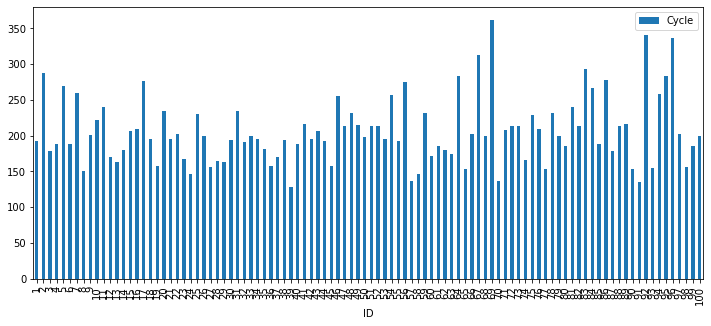

In [8]:
## plot the cycle count for each IDs
raw_data[['ID','Cycle']].groupby(by=['ID']).count().plot(kind='bar',figsize=(12,5))

On an average, there seems to be around 225 cycles per each ID in the dataset. Further, lets check the data-types of the fields and the number of null records in the data.

In [9]:
## check the data-types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               20631 non-null  int64  
 1   Cycle            20631 non-null  int64  
 2   OpSet1           20631 non-null  float64
 3   OpSet2           20631 non-null  float64
 4   OpSet3           20631 non-null  float64
 5   SensorMeasure1   20631 non-null  float64
 6   SensorMeasure2   20631 non-null  float64
 7   SensorMeasure3   20631 non-null  float64
 8   SensorMeasure4   20631 non-null  float64
 9   SensorMeasure5   20631 non-null  float64
 10  SensorMeasure6   20631 non-null  float64
 11  SensorMeasure7   20631 non-null  float64
 12  SensorMeasure8   20631 non-null  float64
 13  SensorMeasure9   20631 non-null  float64
 14  SensorMeasure10  20631 non-null  float64
 15  SensorMeasure11  20631 non-null  float64
 16  SensorMeasure12  20631 non-null  float64
 17  SensorMeasur

The data doesn't have any null records or any categorical fields. Next, lets check the numerical distribution of the fields.

In [10]:
## check the numerical characteristics of the data
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
Cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
OpSet1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
OpSet2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
OpSet3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
SensorMeasure1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
SensorMeasure2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
SensorMeasure3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
SensorMeasure4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
SensorMeasure5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


Features **OpSet3**, **SensorMeasure1**,**SensorMeasure10**, **SensorMeasure18** & **SensorMeasure19** seem to be constant throughout the dataset and thus can be eliminated. Apart from the fields that are constant throughout the data, fields that are correlated highly can also be considered for dropping. Having highly correlated fields in the data often leads to multi-collinearity situation which unnecessarily increases the size of feature-space even if it doesn't affect the accuracy much. Such fields can be identified through correlation-matrices and heatmaps.

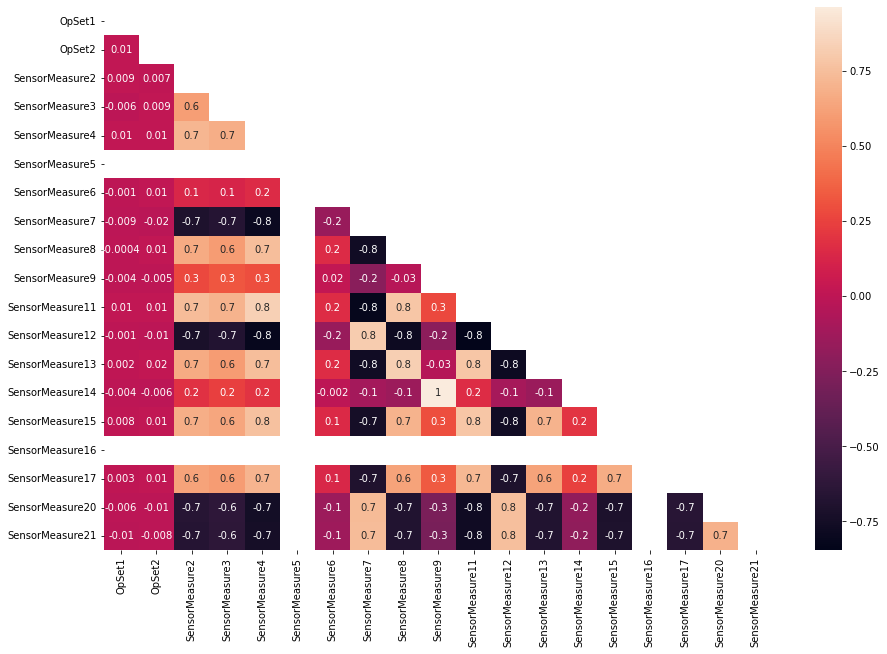

In [20]:
## plot the correlation matrix
plt.figure(figsize = (15,10))
cols = [i for i in raw_data.columns if i not in ['ID','Cycle','OpSet3', 'SensorMeasure1',
                                                 'SensorMeasure10', 'SensorMeasure18', 'SensorMeasure19'
                                                ]]
corr_mat = raw_data[cols].corr()
matrix = np.triu(corr_mat)

sns.heatmap(corr_mat,annot=True,mask=matrix,fmt='.1g')
plt.show()

Fields **SensorMeasure7**, **SensorMeasure12**, **SensorMeasure20** & **SensorMeasure21** correlate highly with many other fields. These fields can be omitted. Further, **SensorMeasure8**, **SensorMeasure11** and **SensorMeasure4** seem highly correlated with each other and so any one of them, say **SensorMeasure4** can be kept and the rest can be omitted.

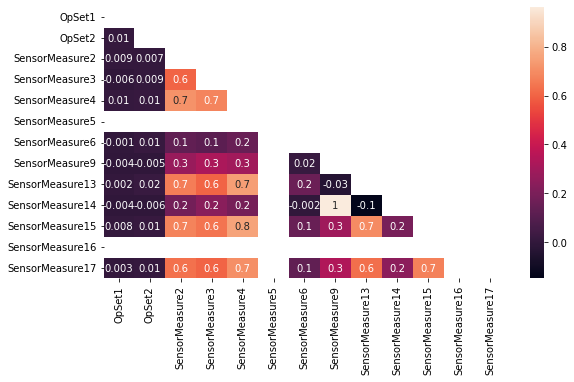

In [23]:
cols = [i for i in cols if i not in ['SensorMeasure7', 'SensorMeasure12', 
                                     'SensorMeasure20','SensorMeasure21', 
                                     'SensorMeasure8', 'SensorMeasure11']]
corr_mat = raw_data[cols].corr()
matrix = np.triu(corr_mat)
plt.figure(figsize=(9,5))
sns.heatmap(corr_mat,annot=True,mask=matrix,fmt='.1g')
plt.show()

As the current objective is to predict the remaining useful life(RUL) of each unit(ID), the target variable needs to be identified. Since we're dealing with a timeseries data that represents the lifetime of a unit, remaining useful life of a unit can be calculated by subtracting the current cycle from the maximum cycle of that unit.

					RUL = Max. Cycle - Current Cycle    
## RUL calculation and Feature selection

In [28]:
## get max-cycle of the ids
cols = ["ID","Cycle"]+cols 
max_cycles_df = raw_data.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})
## merge back to original dataset
FD001_df = pd.merge(raw_data, max_cycles_df, how='inner', on='ID')
## calculate rul from max-cycle and current-cycle 
FD001_df['RUL'] = FD001_df['MaxCycleID'] - FD001_df['Cycle']

To ensure that the target field is generated properly, the RUL field can be plotted.

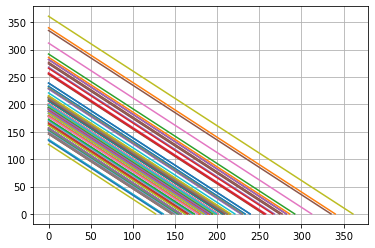

In [16]:
# plot the RUL vs Cycles
one_engine = []
for i,r in FD001_df.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []
        
plt.grid()

The above plot suggests that the RUL i.e., the remaining cycles is decreasing as the current cycle increases which is expected. Further, lets see the how the other fields relate to RUL in the current dataset.

In [ ]:
## plot feature vs the RUL
def plot_feature(feature):
    plt.figure(figsize=(10,5))
    for i in FD001_df['ID'].unique():
        if (i % 10 == 0):  # only plot every 10th ID
            plt.plot('RUL', feature, data=FD001_df[FD001_df['ID']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(feature)
    plt.xlabel('RUL')
    plt.show()
    
for i in cols :
    if i not in ['ID', 'Cycle']:
        plot_feature(i)

The following set of observations can be made from the outcome of the above cell :
- Fields **SensorMeasure5** and **SensorMeasure16** don't show much variance with the RUL and seem constant all the time. Hence, they can be removed.
- Fields **SensorMeasure2**, **SensorMeasure3**, **SensorMeasure4**, **SensorMeasure13**, **SensorMeasure15** & **SensorMeasure17** show a similar rising trend.
- **SensorMeasure9** and **SensorMeasure14** show a similar trend.
- **SensorMeasure6** shows flatline most of the time except at a very few places and therefore can be ignored.

In [38]:
## remove the unnecessary fields
cols = [i for i in cols if i not in ['ID', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure16']]
cols

['Cycle',
 'OpSet1',
 'OpSet2',
 'SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure9',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17']

## Split the data into Train and Test

Divide the dataset with the selected features into train and test sets.

In [39]:
## split data into train and test
X = FD001_df[cols].copy()
y = FD001_df['RUL'].copy()

## split the data into 70-30 ratio of train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=36)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14441, 11), (14441,), (6190, 11), (6190,))

## Fit a Regression model
<a name="section-6"></a>
Initialize and train a regression model using XGBoost library with the calculated RUL as the target feature.

In [40]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluate the trained model
<a name="section-7"></a>

Check the R2 scores of the model on train and test sets.

In [41]:
## print test R2 score
y_train_pred = model.predict(X_train)
train_score = r2_score(y_train, y_train_pred)
y_test_pred = model.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
print ("Train score:",train_score)
print ("Test score:",test_score)

Train score: 0.880913287930797
Test score: 0.7011615471434914


Check the RMSE errors on train and test sets.

In [42]:
## print train and test RMSEs
train_error = mean_squared_error(y_train, y_train_pred, squared=False)
test_error = mean_squared_error(y_test, y_test_pred, squared=False)
print ("Train error:",train_error)
print ("Test error:",test_error)

Train error: 23.80309418944036
Test error: 37.52822238055519


Plot the predicted values against the target values. The closer the plot to a straight line passing through origin with a unit slope, the better the model. 

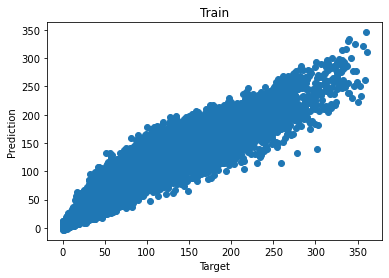

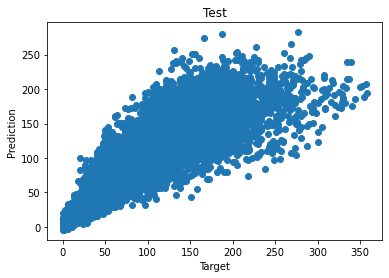

In [24]:
## plot the train and test predictions
plt.scatter(y_train,y_train_pred)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Train')
plt.show()
plt.scatter(y_test,y_test_pred)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Test')
plt.show()

## Save the model
<a name="section-8"></a>

Save the model to a booster file.

In [43]:
# save the trained model to a local file "model.bst"
FILE_NAME = "model.bst"
model.save_model(FILE_NAME)

Copy the model to the cloud-storage bucket

In [46]:
# Upload the saved model file to Cloud Storage
BLOB_PATH = "mfg_predictive_maintenance/"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)
bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Running a notebook end-to-end using **Executor**
<a name="section-9"></a>

### Automating the notebook execution
All the steps followed till now can be run as a training job without using any additional code using the Notebook executor. Notebook executor can help you run a notebook file from start to end, with your choice of the environment, machine type, input parameters, and other characteristics. After setting up an execution, the notebook is executed as a job in Vertex AI custom training. Your jobs can be monitored from the Notebook Executor pane in the menu on the left.

<img src="images/executor.PNG">

Executor also lets you choose the environment and machine type while automating the runs similar to Vertex AI training jobs without switching to the training jobs UI. Apart from the custom container that replicates the existing kernel by default, pre-built environments like TensorFlow Enterprise, PyTorch, and others can also be selected to run the notebook. Furthermore the required compute power can be specified by choosing from the list of machine types available, including GPUs.

## Scheduled runs on executor
Notebook runs can also be scheduled recurringly with the executor. To do so, select Schedule-based recurring executions as the run type instead of One-time execution. The frequency of the job and the time when it executes is provided when you create the execution.

<img src="https://storage.googleapis.com/gweb-cloudblog-publish/images/7_Vertex_AI_Workbench.max-1100x1100.jpg">

## Parameterizing the variables
Executor lets you run a notebook with different sets of input parameters.If you’ve added parameter tags to any of your notebook cells, you can pass in your parameter values to the executor. More about how to use this feature can be found on this [blog](https://cloud.google.com/blog/products/ai-machine-learning/schedule-and-execute-notebooks-with-vertex-ai-workbench).

<img src="https://storage.googleapis.com/gweb-cloudblog-publish/images/6_Vertex_AI_Workbench.max-700x700.jpg">



## Hosting the model on Vertex AI
<a name="section-10"></a>

### Create a model resource

The saved model from the cloud storage can be deployed easily using the Vertex-AI sdk. To do so, first create a model resource.

In [27]:
ARTIFACT_GCS_PATH = f"gs://{BUCKET_NAME}/{BLOB_PATH}"


In [ ]:
# Create a Vertex AI model resource
aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-1:latest",
)

model.wait()

print(model.display_name)
print(model.resource_name)

### Create an Endpoint
<a name="section-11"></a>


Next, create an endpoint resource for deploying the model.

In [29]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

print(endpoint.display_name)
print(endpoint.resource_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/931647533046/locations/us-central1/endpoints/6327636641292746752/operations/9115834370819620864
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/931647533046/locations/us-central1/endpoints/6327636641292746752
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/931647533046/locations/us-central1/endpoints/6327636641292746752')
rul_prediction_endpoint1
projects/931647533046/locations/us-central1/endpoints/6327636641292746752


### Deploy the model to the created Endpoint
<a name="section-12"></a>


Configure the deployment name, machine type, and other parameters for the deployment and deploy the model to the created endpoint.

In [30]:
MACHINE_TYPE = "n1-standard-2"

In [31]:
# deploy the model to the endpoint
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/931647533046/locations/us-central1/endpoints/6327636641292746752
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/6327636641292746752/operations/4256450372886855680
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/931647533046/locations/us-central1/endpoints/6327636641292746752
rul_prediction
projects/931647533046/locations/us-central1/models/1583793723253194752


## Test calling the endpoint
<a name="section-13"></a>

Send some sample data to the deployed model on the endpoint to get predictions.

In [46]:
## get predictions on sample data
instances = X_test.iloc[0:2].to_numpy().tolist()
print (endpoint.predict(instances=instances).predictions)

[162.6863403320312, 143.4859466552734]

## Clean up
<a name="section-14"></a>

Undeploy the model from endpoint.

In [49]:
DEPLOYED_MODEL_ID = ""
endpoint.undeploy(deployed_model_id=DEPLOYED_MODEL_ID)

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/931647533046/locations/us-central1/endpoints/6327636641292746752
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/6327636641292746752/operations/6784095663748546560
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/931647533046/locations/us-central1/endpoints/6327636641292746752


Delete the endpoint.

In [50]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/931647533046/locations/us-central1/endpoints/6327636641292746752
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/931647533046/locations/us-central1/operations/4455734656398000128
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/931647533046/locations/us-central1/endpoints/6327636641292746752


Delete the model.

In [51]:
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/931647533046/locations/us-central1/models/1583793723253194752
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/931647533046/locations/us-central1/operations/5554612965476401152
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/931647533046/locations/us-central1/models/1583793723253194752


Remove the contents of the Cloud Storage bucket.

In [ ]:
! gsutil -m rm -r $BUCKET_URI